In [ ]:
import cv2
import scipy.signal.windows
import sim2
import glob
import xyy_lib as xyy
import scipy
import torch
import aotools
import numpy as np
import matplotlib
matplotlib.use("qt5agg")
%matplotlib inline
import matplotlib.patches as patches
from tqdm.notebook import tqdm
from Pro_net import ResNet as NET
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.metrics import structural_similarity as compare_ssim
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 9,
    'font.weight': 'normal',
    'font.family': 'Times New Roman',
    'axes.titlesize': 9,
    'axes.titleweight': 'bold',
    # 'figure.figsize': (7.2, 3.5),
    'figure.dpi': 600
})


In [2]:
device = 'cuda'
print("cuda is available:{}".format(torch.cuda.is_available()))

cuda is available:True


In [3]:
INPUTCH=4
CONVNUM=32
LAYERS=36
OUTPUTCH=1
BATCHSIZE=1
PHASE_DEFOCUS = sim2.fitsread('df_phase.fits')[ 0 ]
PHASE_DEFOCUS = cv2.resize(PHASE_DEFOCUS, (50, 50))
PUPIL_SIZE = 100
PUPIL_CLIP50 = aotools.circle(PUPIL_SIZE //4, PUPIL_SIZE//2 ).astype(np.float32)
PUPIL_CLIP48 = aotools.circle(PUPIL_SIZE //4-1, PUPIL_SIZE//2 ).astype(np.float32)
PUPIL_CLIP48_SPIDER = aotools.circle(PUPIL_SIZE //4-1, PUPIL_SIZE//2 ).astype(np.float32)-aotools.circle(PUPIL_SIZE //4//4, PUPIL_SIZE//2 ).astype(np.float32)
PUPIL_CLIP48_SPIDER[25,:]=0
PUPIL_CLIP48_SPIDER[:,25]=0
PUPIL_CLIP98 = aotools.circle(PUPIL_SIZE //2-1, PUPIL_SIZE ).astype(np.float32)
PUPIL_100 = aotools.circle(25, PUPIL_SIZE ).astype(np.float32)
PUPIL_CLIP128_SPIDER = aotools.circle(128 //2-1, 128 ).astype(np.float32)-aotools.circle(128 //2//4, 128 ).astype(np.float32)
PUPIL_CLIP128_SPIDER[63:65,:]=0
PUPIL_CLIP128_SPIDER[:,63:65]=0
ZERNIKE_PTT = aotools.zernikeArray(3,50)
ZERNIKE_105 = aotools.zernikeArray(105,50)
K=3

In [4]:
def pupil_fft(modulus, phase):
    phase_big = np.zeros((100,100))
    phase_big[25:75,25:75] = phase * PUPIL_CLIP50
    pupil_func = modulus * np.exp(1j * phase_big)
    pupil_func = np.fft.ifft2(pupil_func)
    pupil_psf = np.abs(pupil_func)**2
    psf = np.fft.fftshift(pupil_psf)
    pupil_psf = np.fft.fft2(pupil_psf)
    pupil_psf = pupil_psf/pupil_psf.max()
    otf = np.fft.fftshift(pupil_psf)
    return psf, otf

(-0.5, 99.5, 99.5, -0.5)

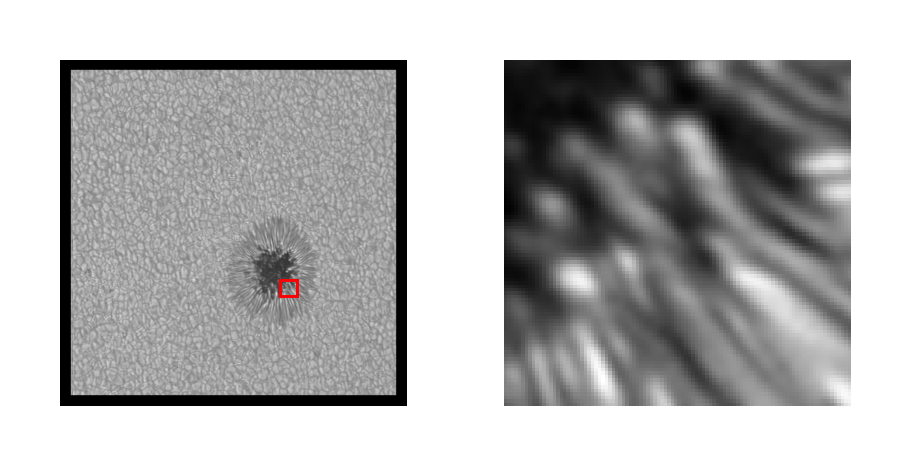

In [5]:
"""目标载入和截取子块"""

img_obj_big= sim2.fitsread('./output2.fits')[0]
top_left_x = 1300
top_left_y = 1300

WDITH = 100
img_obj = img_obj_big[top_left_x:top_left_x+WDITH,top_left_y:top_left_y+WDITH]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(1.75, 0.75))
ax1.imshow(img_obj_big,cmap = 'gray')
rect = patches.Rectangle((top_left_x, top_left_y), WDITH, WDITH, linewidth=0.35,edgecolor='red', facecolor='none')
ax1.add_patch(rect)
ax2.imshow(img_obj,cmap = 'gray')
ax1.axis("off")
ax2.axis("off")

""" PSF和OTF """

(-0.5, 99.5, 99.5, -0.5)

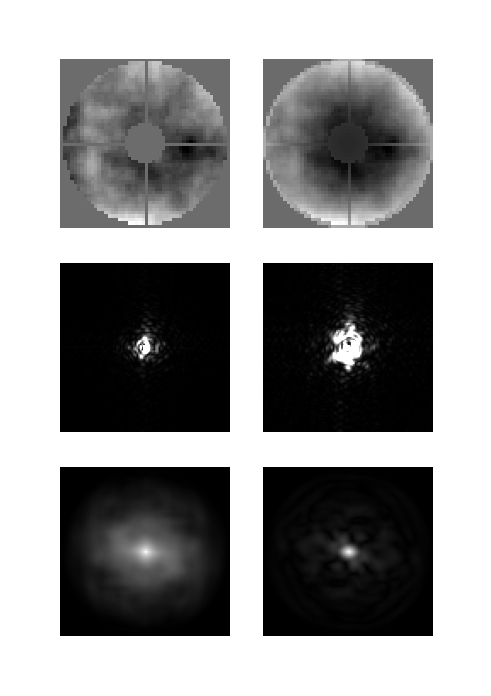

In [6]:
phase_ori = sim2.fitsread(r'./r0_10cm_053.fits')[0][390] # 一个fits里有400个相位屏
phase_ori = phase_ori * PUPIL_CLIP48
phase_ptt_coef = np.sum(phase_ori*ZERNIKE_PTT,axis=(1,2))/np.sum(PUPIL_CLIP48)
phase_ptt = aotools.phaseFromZernikes(phase_ptt_coef,50)
phase = (phase_ori-phase_ptt) * PUPIL_CLIP48_SPIDER
psf_focus, otf_focus = pupil_fft(PUPIL_100,phase)
psf_defocus, otf_defocus = pupil_fft(PUPIL_100,phase+PHASE_DEFOCUS)

# 创建子图
fig, ax = plt.subplots(3, 2, figsize=(0.8, 1.25))  # 调整了 figsize
ax[0, 0].imshow(phase, cmap='gray')
ax[0, 0].axis("off")
ax[0, 1].imshow((phase + PHASE_DEFOCUS), cmap='gray')
ax[0, 1].axis("off")
im=psf_focus
mi = np.max([im.min(), im.mean() - K * im.std()])
mx = np.min([im.max(), im.mean() + K * im.std()])
ax[1, 0].imshow(im , cmap='gray',vmin=mi,vmax=mx)
ax[1, 0].axis("off")
im=psf_defocus
mi = np.max([im.min(), im.mean() - K * im.std()])
mx = np.min([im.max(), im.mean() + K * im.std()])
ax[1, 1].imshow(im , cmap='gray',vmin=mi,vmax=mx)  # 使用对数尺度增强显示
ax[1, 1].axis("off")
ax[2, 0].imshow(np.log(np.abs(otf_focus)+1), cmap='gray')
ax[2, 0].axis("off")
ax[2, 1].imshow(np.log(np.abs(otf_defocus)+1), cmap='gray')  # 使用对数尺度增强显示
ax[2, 1].axis("off")

(-0.5, 99.5, 99.5, -0.5)

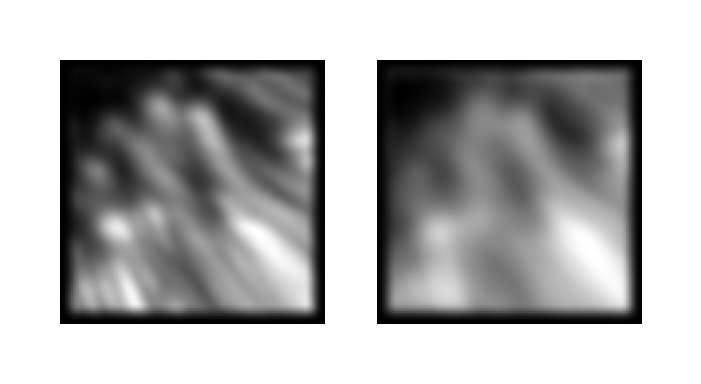

In [7]:
img_obj_fft = np.fft.fftshift(np.fft.fft2(img_obj))
img_distort_fft_focus = img_obj_fft * otf_focus
img_distort_fft_defocus = img_obj_fft * otf_defocus
winbp = scipy.signal.windows.tukey(100,0.15)
winbp = np.outer(winbp,winbp)
img_distort_focus = sim2.imnorm(np.real(
    np.fft.ifft2(np.fft.ifftshift(
        img_distort_fft_focus)
    ))) * winbp
img_distort_defocus = sim2.imnorm(np.real(
    np.fft.ifft2(np.fft.ifftshift(
        img_distort_fft_defocus)
    )))* winbp

# 创建子图
fig, ax = plt.subplots(1, 2, figsize=(1.25, 0.8))  # 调整了 figsize
ax[0].imshow(img_distort_focus, cmap='gray')
ax[0].axis("off")
ax[1].imshow(img_distort_defocus, cmap='gray')
ax[1].axis("off")


(-0.5, 99.5, 99.5, -0.5)

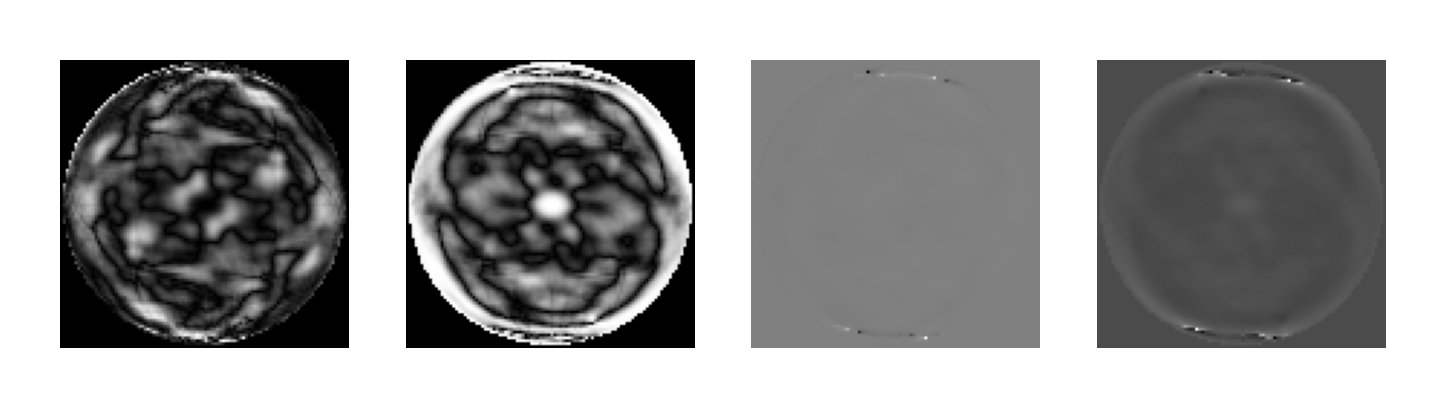

In [8]:
"""Preprocessing"""
power_test = np.abs(img_distort_fft_focus) ** 2 \
                + np.abs(img_distort_fft_defocus) ** 2
prep1i = sim2.removenan(np.abs(
    img_distort_fft_defocus * img_distort_fft_focus.conjugate()
    - img_distort_fft_defocus.conjugate() * img_distort_fft_focus)
    / power_test) * PUPIL_CLIP98
prep1r = sim2.removenan(np.abs(
    img_distort_fft_focus * img_distort_fft_defocus.conjugate()
    + img_distort_fft_focus.conjugate() * img_distort_fft_defocus)
    / power_test) * PUPIL_CLIP98
prep2 = sim2.removenan(
    img_distort_fft_defocus
    / (img_distort_fft_focus + 0.0001)) * PUPIL_CLIP98
# 创建子图 prep1i,prep1r,prep2.imag / 100,prep2.real / 100
fig, ax = plt.subplots(1, 4, figsize=(2.85, 0.85))  # 调整了 figsize
ax[0].imshow(prep1i, cmap='gray')
ax[0].axis("off")
ax[1].imshow(prep1r, cmap='gray')
ax[ 1].axis("off")
ax[2].imshow(prep2.imag / 100 , cmap='gray')
ax[2].axis("off")
ax[3].imshow(prep2.real / 100 , cmap='gray')
ax[3].axis("off")


Residual RMS WFE:0.3474990096638787rad


(-0.5, 49.5, 49.5, -0.5)

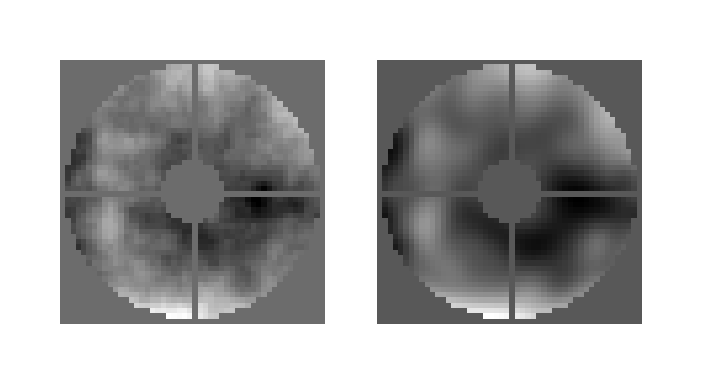

In [9]:
"""output"""
model_path = r'./Model_liu/pd_net.mod'
model = NET(INPUTCH, CONVNUM, LAYERS, OUTPUTCH, BATCHSIZE).to(device)
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)
model.eval()
model_input = np.stack((prep1i,prep1r,prep2.imag/100,prep2.real/100),axis=0)
model_input = np.ascontiguousarray(model_input, dtype = np.float32)
model_input = torch.from_numpy(model_input).repeat(1, 1, 1, 1).to(device)
phase_est = model(model_input)
phase_est = phase_est[ 0, 0 ].cpu().detach().numpy()
phase_est = phase_est * PUPIL_CLIP48

print('Residual RMS WFE:{}rad'.format(np.std(phase-phase_est)))
# 创建子图
fig, ax = plt.subplots(1, 2, figsize=(1.25, 0.8))
ax[0].imshow(phase, cmap='gray')
ax[0].axis("off")
ax[1].imshow(phase_est*PUPIL_CLIP48_SPIDER, cmap='gray')
ax[1].axis("off")

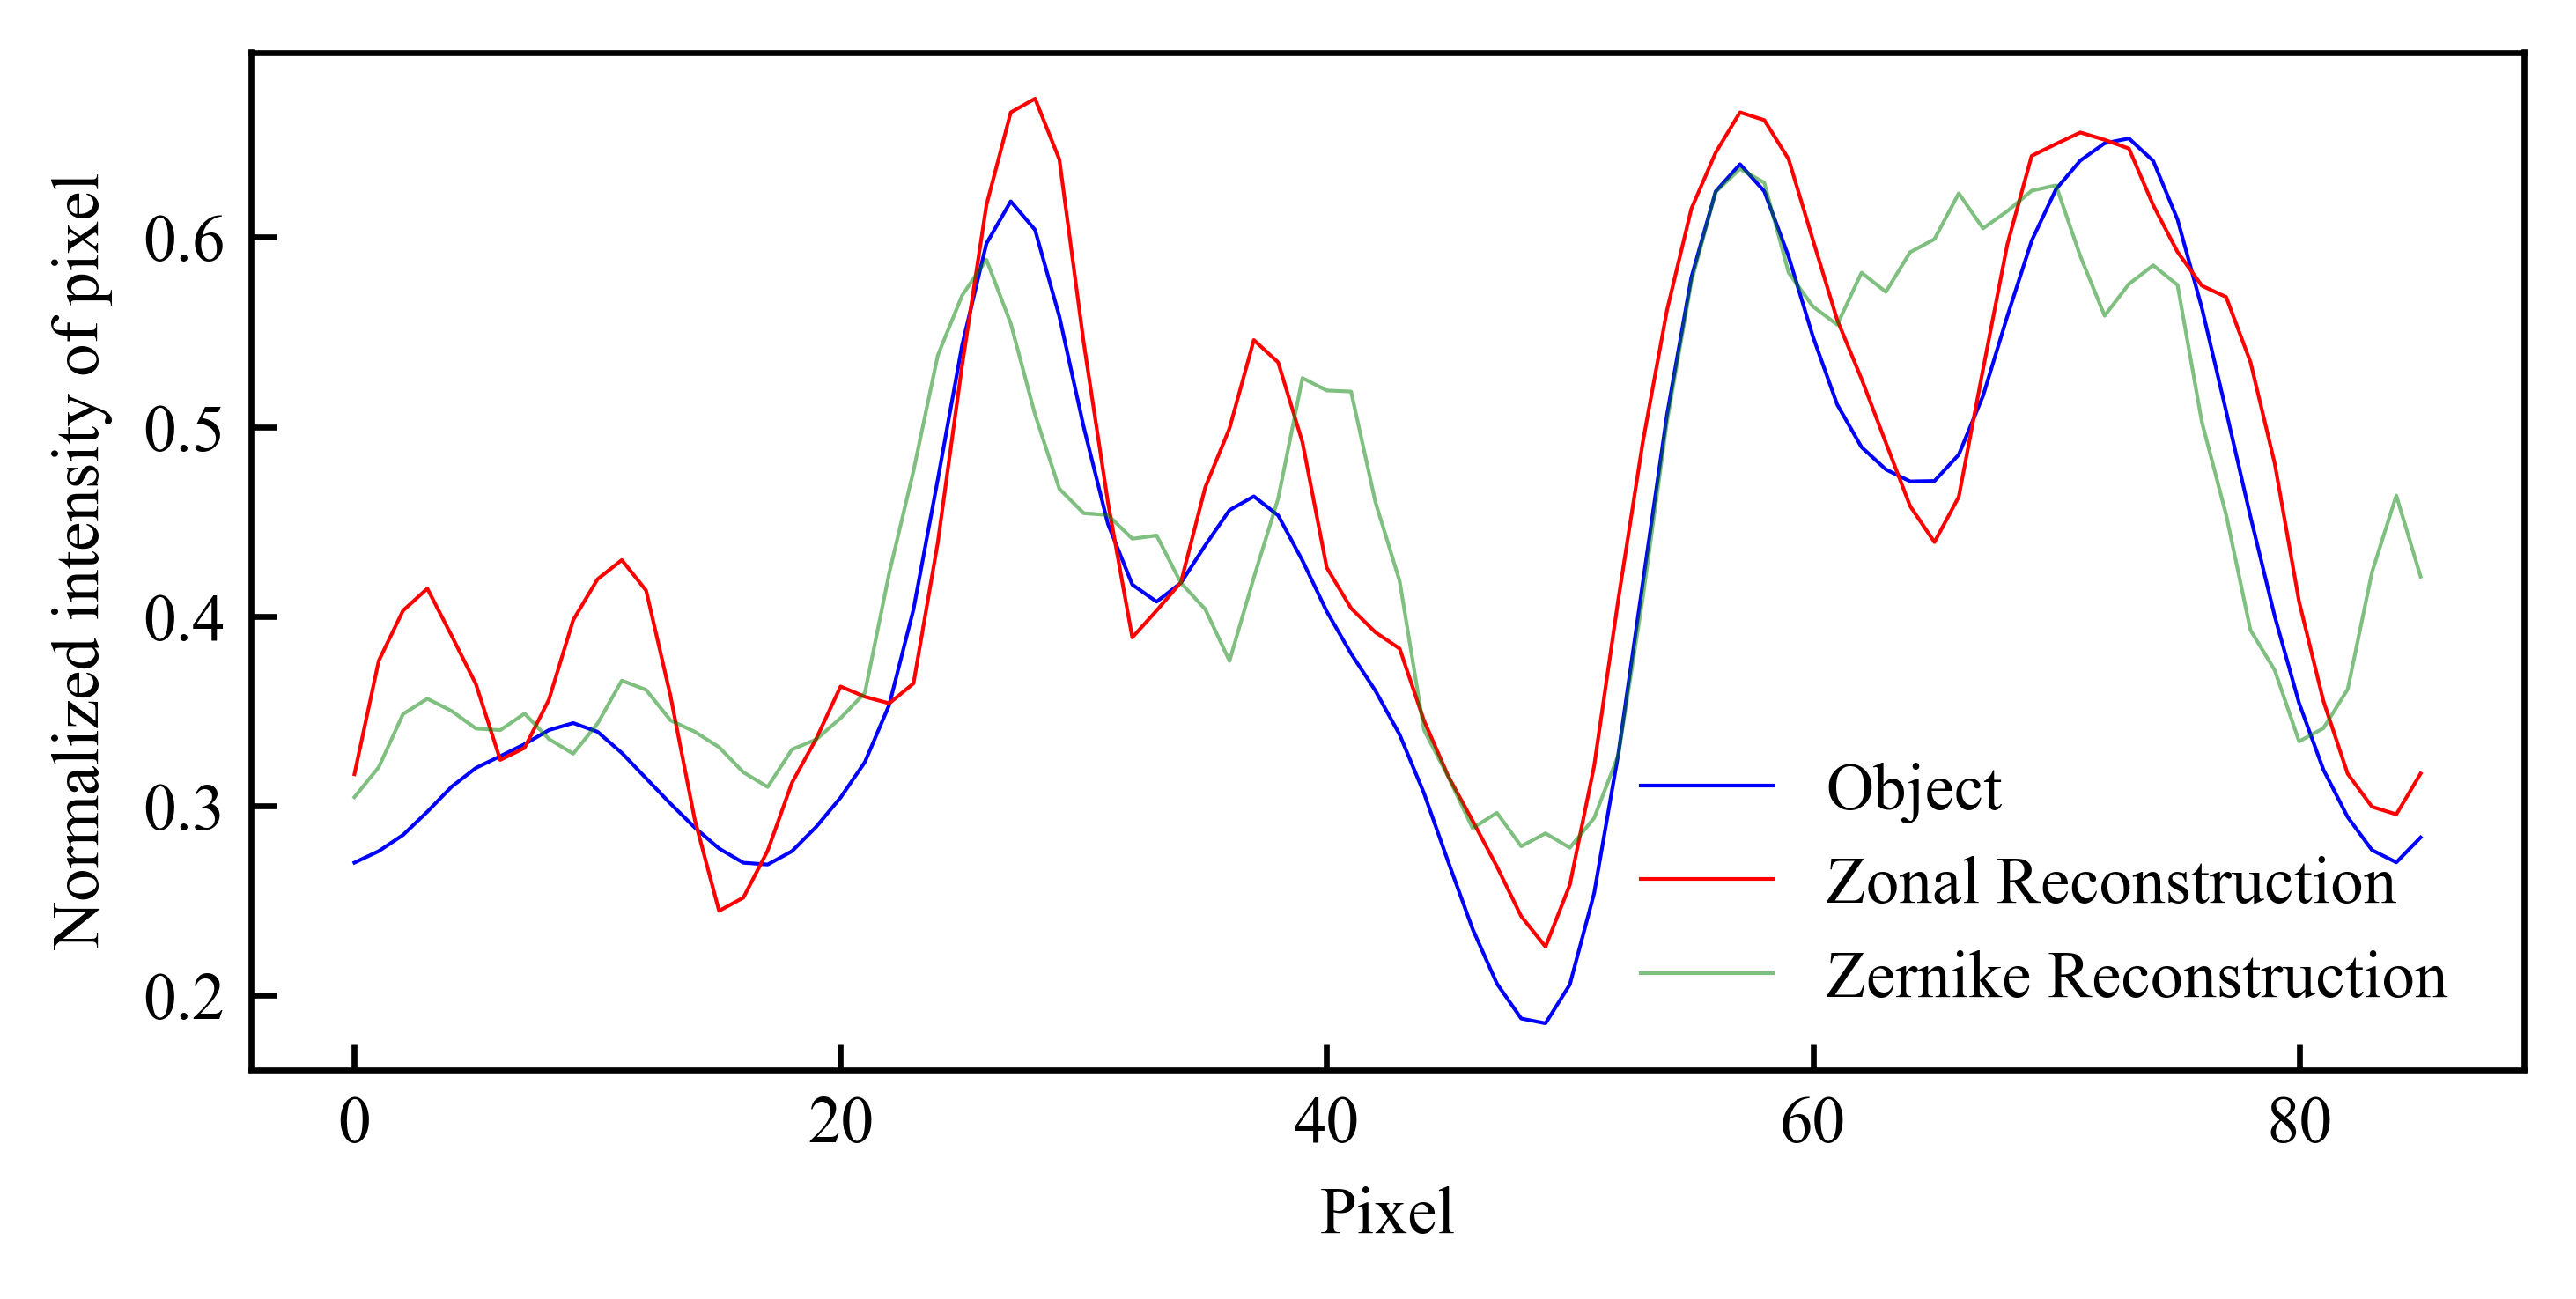

In [17]:
"""截线强度对比"""
fig, ax = plt.subplots(1, 1, figsize=(5.55, 2.5))
ax.plot(sim2.imnorm(img_obj)[55, 7:-7], lw=0.5, color='blue', label='Object')
ax.plot(sim2.imnorm(obj_est)[55, 7:-7], lw=0.5, color='red', alpha=1, label='Zonal Reconstruction ')
ax.plot(sim2.imnorm(obj_est_z)[55, 7:-7], lw=0.5, color='green', alpha=0.5, label='Zernike Reconstruction ')
# ax.set_xticks([0, 25, 50, 75, 97])
# ax.set_xticklabels(['7', '25', '50', '75', '97'], rotation=0)  #
ax.set_xlabel('Pixel')
ax.set_ylabel('Normalized intensity of pixel')
ax.tick_params(direction='in')
ax.legend(frameon=False,loc='lower right')



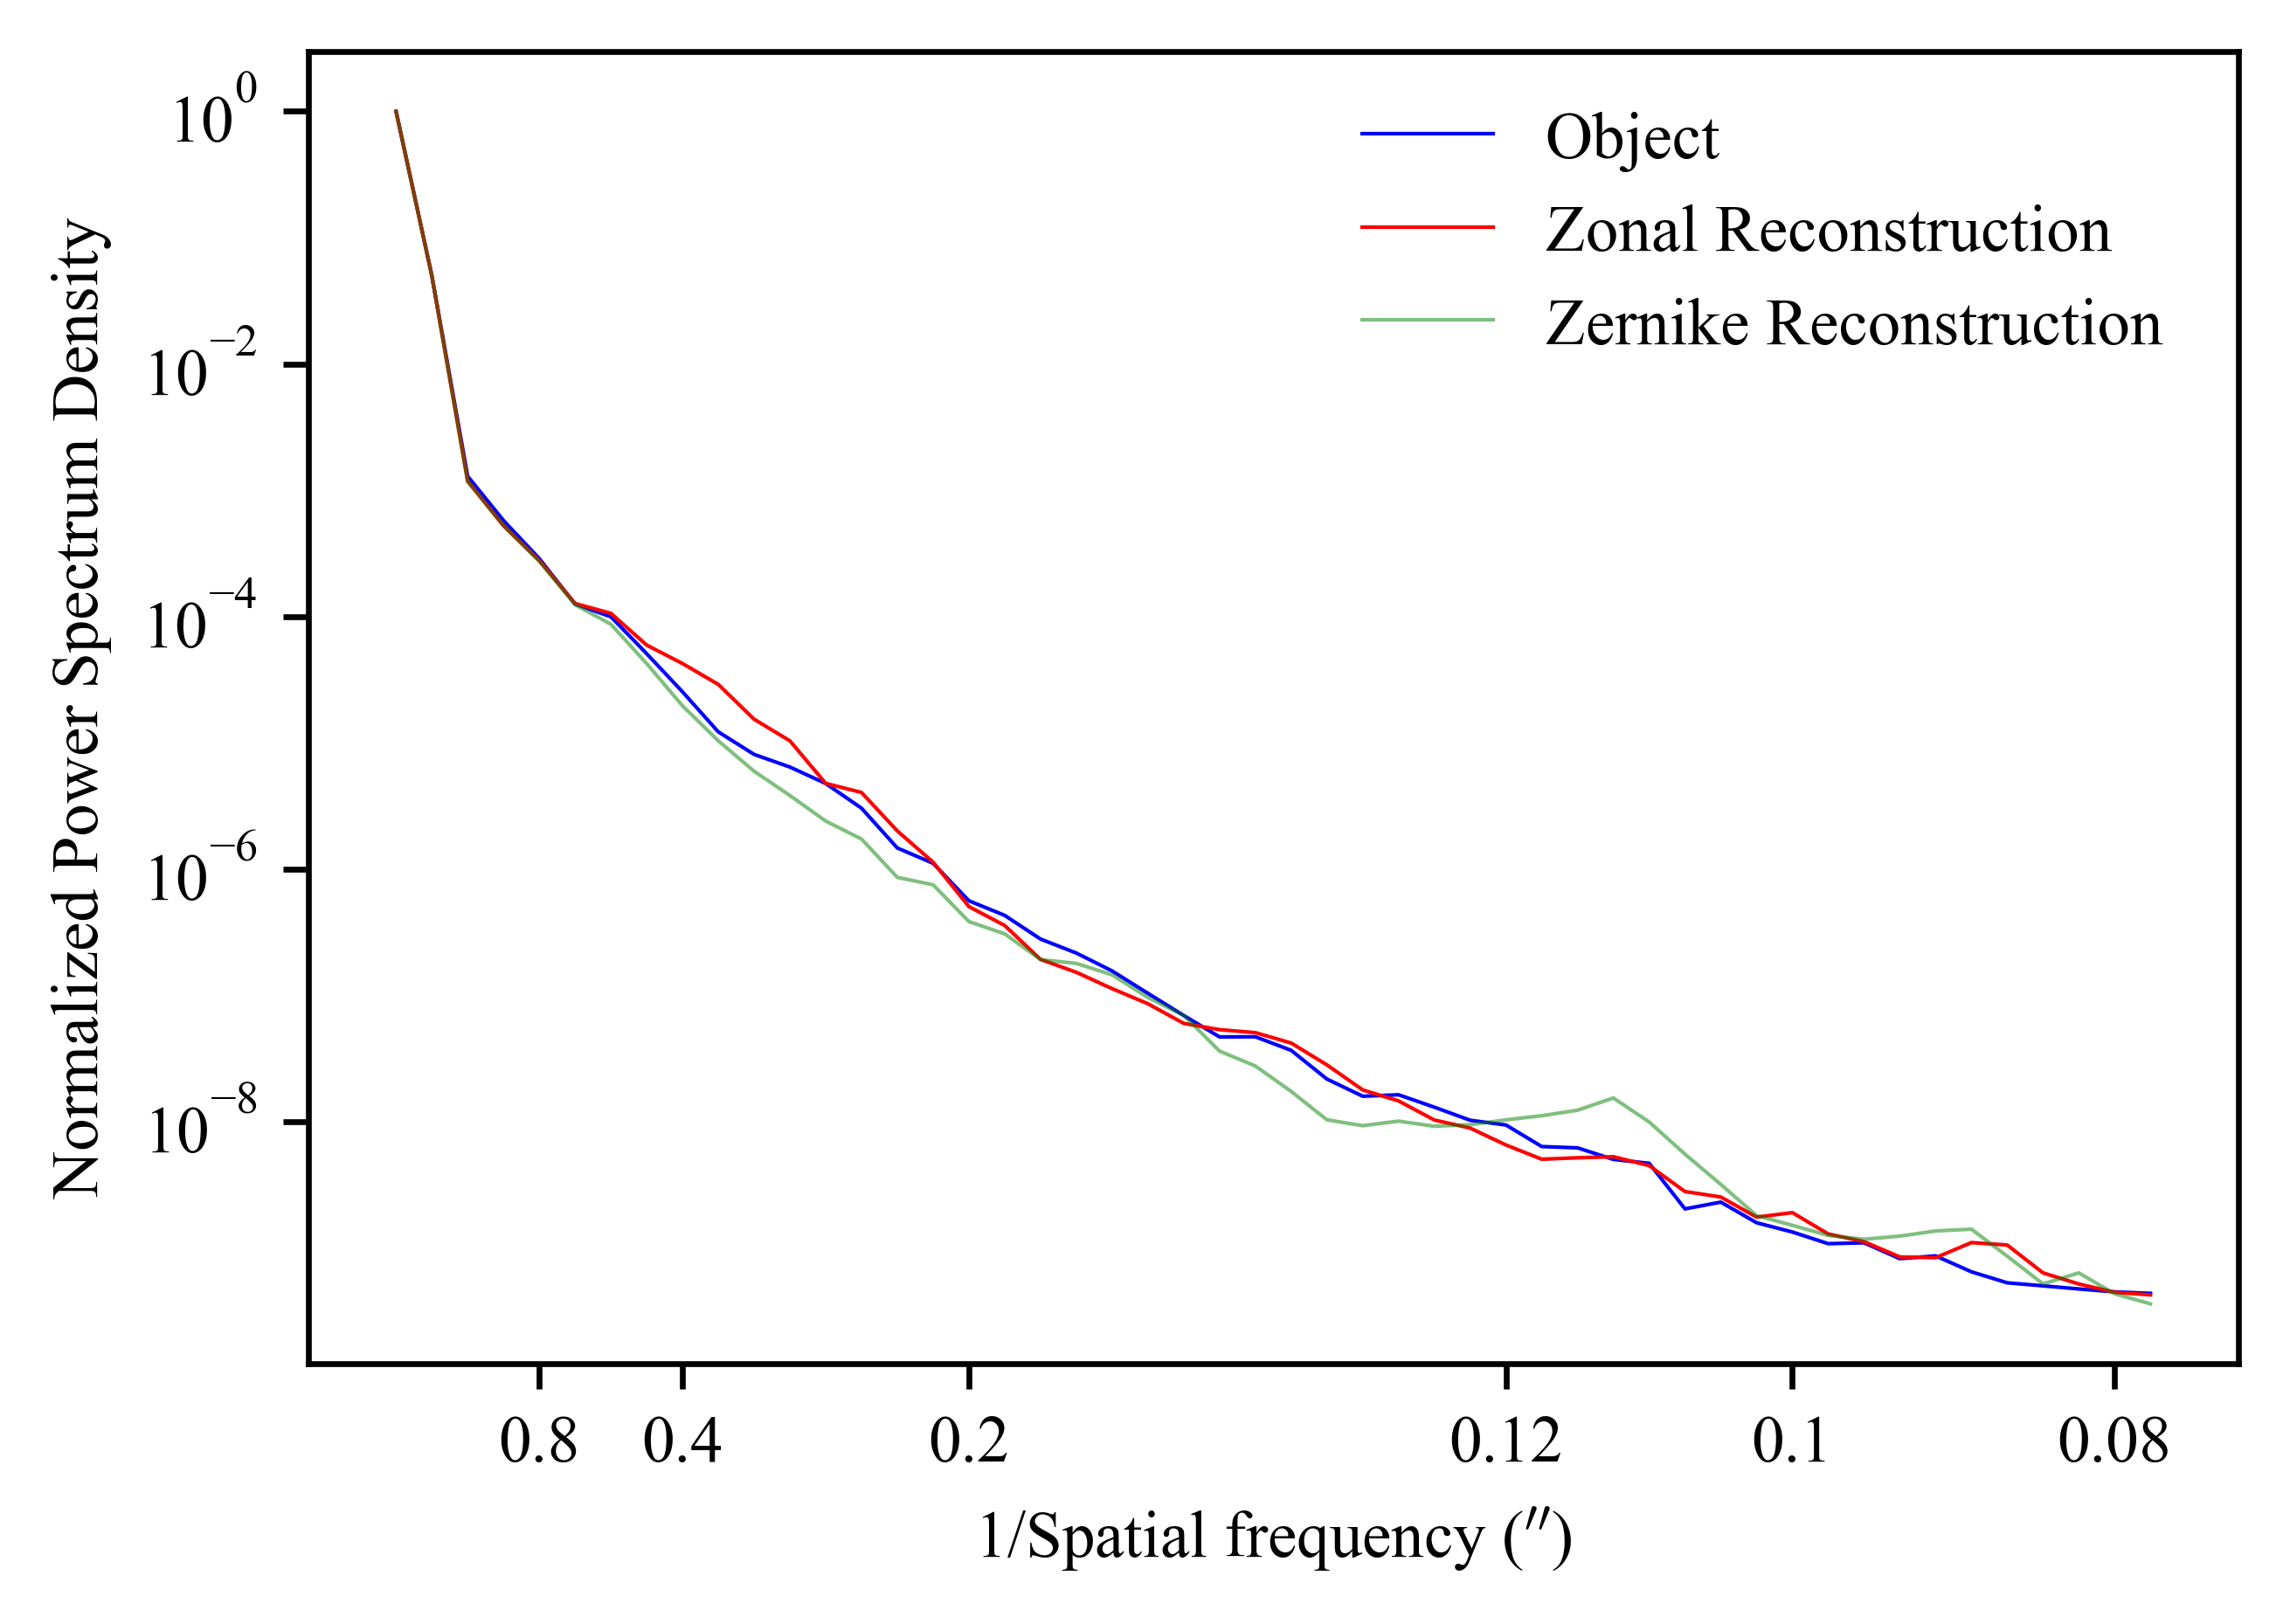

In [18]:
""" power spectrum density """
import sim

sx = 1/np.linspace(1/100, 1/2, 50) * 0.0385
obj_psd, _ = sim.image_power_spectrum(img_obj)
obj_psd /= obj_psd[0]  # 归一化功率谱
zonal_psd, _ = sim.image_power_spectrum(obj_est)
zonal_psd /= zonal_psd[0]
zernike_psd, _ = sim.image_power_spectrum(obj_est_z)
zernike_psd /= zernike_psd[0]
fig, ax = plt.subplots(1, 1, figsize=(4.75, 3.25))
ax.plot(obj_psd, label='Object', color='blue',lw=0.5)
ax.plot(zonal_psd, label='Zonal Reconstruction ', color='red',lw=0.5)
ax.plot(zernike_psd, label='Zernike Reconstruction ', color='green',lw=0.5,alpha=0.5)

ax.set_xlabel('1/Spatial frequency ($^{\prime \prime}$)')
ax.set_ylabel('Normalized Power Spectrum Density')
ax.set_yscale('log')  # 设置 y 轴为对数尺度
ax.legend()
ax.set_xticks([4, 8, 16, 31, 39, 48])
ax.set_xticklabels([np.round(sx[4], decimals=1), np.round(sx[8], decimals=1), np.round(sx[16], decimals=1),
                    np.round(sx[31], decimals=2), np.round(sx[39], decimals=2), np.round(sx[48], decimals=2)])
ax.legend(frameon=False)